## MLPClassifier

`Overview`: An MLP consists of multiple layers of interconnected nodes (neurons), with each layer transforming the input data through weighted connections and activation functions. This architecture enables MLPs to model complex, non-linear relationships within the data.

C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-20 21:00:49,128] A new study created in memory with name: no-name-c184b681-6d10-4ba4-b1d8-723e6d76d85d
[I 2024-12-20 21:00:54,795] Trial 0 finished with value: 0.8115510204081633 and parameters: {'hidden_layer_size': 153, 'alpha': 0.06370695431128272, 'learning_rate_init': 0.011864748582997676, 'activation': 'logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8115510204081633.
[I 2024-12-20 21:00:55,461] Trial 14 finished with value: 0.811734693877551 and parameters: {'hidden_layer_size': 154, 'alpha': 0.013887286631782044, 'learning_rate_init': 0.009665233047213461, 'activation': 'logistic', 'solver': 'adam'}. Best is trial 14

Best Hyperparameters: {'hidden_layer_size': 51, 'alpha': 0.008012972984215288, 'learning_rate_init': 0.013371231563272301, 'activation': 'logistic', 'solver': 'adam'}
Best Value: 0.826
Mean Cross-Validation Accuracy: 0.8028571428571428
Mean Cross-Validation Precision: 0.846984126984127
Mean Cross-Validation Recall: 0.7732142857142857
Mean Cross-Validation F1 Score: 0.7937976239446828
Mean Cross-Validation AUC Score: 0.8607142857142858
Mean Cross-Validation Specificity: 0.8285714285714286


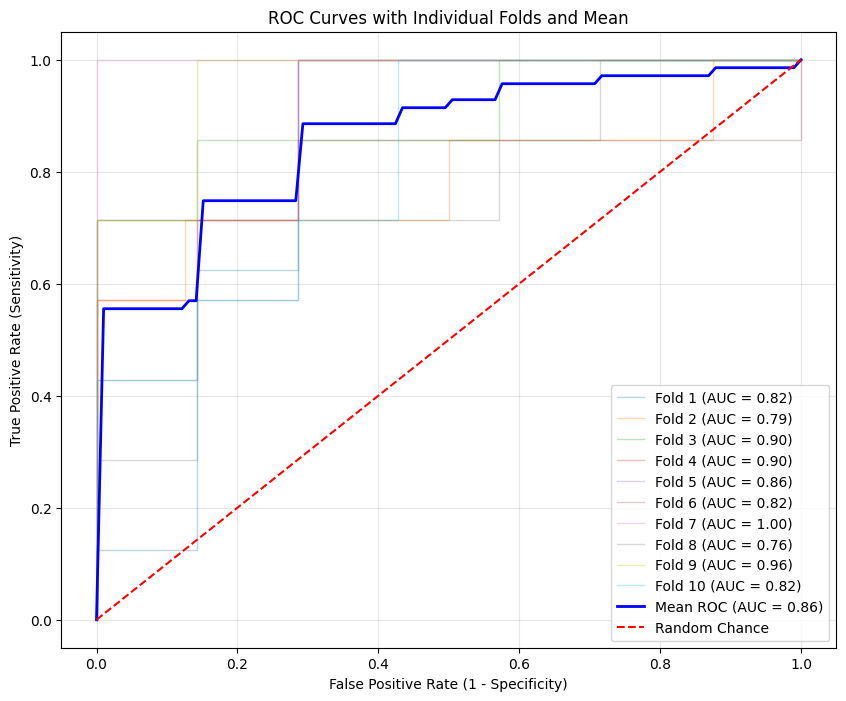

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, auc
from sklearn.neural_network import MLPClassifier

# Load the teams data
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'Rank', 'PlayoffProgScore', 'FTA', 'DREB', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

# Scale the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)

# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

# ============================
# Define the MLP model creation function
# ============================
def create_model(trial):
    # Suggest hyperparameters for MLPClassifier
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 50, 200)
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'adam']) 
    # 'sgd' often requires more tuning and time, we'll just pick lbfgs/adam here for demonstration.

    return MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size,),
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        activation=activation,
        solver=solver,
        max_iter=1000,
        random_state=42
    )

# ============================
# Hyperparameter Tuning with Optuna
# ============================
def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.6 * mean_accuracy + 0.4 * mean_auc

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)  # Reduced trials for demonstration; adjust as needed.

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)

final_model = MLPClassifier(
    hidden_layer_sizes=(best_params['hidden_layer_size'],),
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42
)

# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Using .iloc to access DataFrame rows
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


The highest-performing fold (Fold 7) achieves an ideal classification (AUC = 1.00), indicating that the model perfectly distinguishes between classes in that fold. Most folds (Folds 3, 4, 5, and 9) have `AUC` values above 0.85, demonstrating consistent strong performance.

The model demonstrates strong performance across most folds, with minimal deviation from the `mean ROC`.

While the `MLPClassifier` outperforms the `Logistic Regression` and `SVM` models on average, it also exhibits higher variance, with `AUC` ranging from 0.76 to 1.00. This variability may indicate sensitivity to certain data splits.